# 05 - Defending against Adversarial Examples

We saw how to attack models, but we also need to take into account defending against them.
In particular, we will learn here how to create a simplified version of **adversarial training**.

As seen in class, this technique is defined as:
$$
\min_{\boldsymbol{\theta}} \sum_{(\boldsymbol{x},y) \in D} \max_{\boldsymbol{\delta}} L(\boldsymbol{x}+\boldsymbol{\delta}, y;\boldsymbol{\theta})
$$

which accounts for computing the best parameters $\boldsymbol{\theta}$ that minimizes the error in the presence of worst-case adversarial noise $\boldsymbol{\delta}$.

This is nice in theory, but implementing this is hard and resource demanding.

- For each sample in my set I want to maximize the error
- I am asking the model to still attributing the right label y even after the application of delta
- How can we solve the min max problem?

In [52]:
try:
    import secmlt
except ImportError:
    print("Installing the dependancies")
    %pip install git+https://github.com/pralab/secml-torch


In [53]:
import torch
import numpy as np
import random

seed = 999 # number given to the framework to randomize in a repetible way
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from secmlt.models.pytorch.base_pytorch_trainer import BasePyTorchTrainer
from secmlt.metrics.classification import Accuracy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
import torch


def plot_decision_regions(model, X, y, title="Decision Regions"):
    """
    Plot decision regions for a PyTorch model.
    
    Args:
        model: PyTorch model (must be in eval mode)
        X: Input features as tensor
        y: Labels as tensor
        title: Plot title
    """
    # Convert tensors to numpy for plotting
    X_np = X.detach().numpy()
    y_np = y.detach().numpy()
    
    # Create a mesh grid
    x_min, x_max = X_np[:, 0].min() - 0.5, X_np[:, 0].max() + 0.5
    y_min, y_max = X_np[:, 1].min() - 0.5, X_np[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                        np.linspace(y_min, y_max, 200))
    
    # Get predictions for each point in the mesh
    X_mesh = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    with torch.no_grad():
        model.eval()
        Z = model(X_mesh)
        Z = torch.argmax(Z, dim=1)
    Z = Z.numpy().reshape(xx.shape)
    
    # Plot decision regions
    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
    
    # Plot data points
    scatter = plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, 
                         cmap='viridis')
    
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(title)
    plt.show()


centers = [(0, 1), (0, 0), (1, 1)]
cluster_std = 0.25
X_train, y_train = make_blobs(n_samples=300, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test, y_test = make_blobs(n_samples=100, 
                  centers=centers,
                  n_features=2,
                  cluster_std=cluster_std,
                  random_state=seed)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


tr_dataloader = DataLoader(TensorDataset(X_train, y_train), batch_size=32, shuffle=False)
ts_dataloader = DataLoader(TensorDataset(X_test, y_test), batch_size=5, shuffle=False)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(2, 32)  
        self.fc2 = torch.nn.Linear(32, 16)
        self.fc3 = torch.nn.Linear(16, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

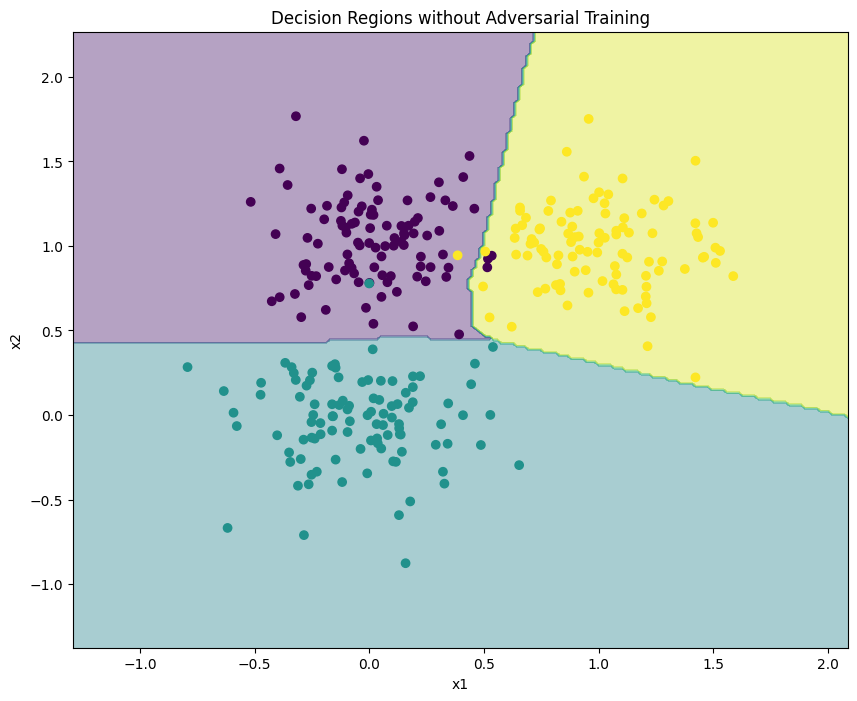

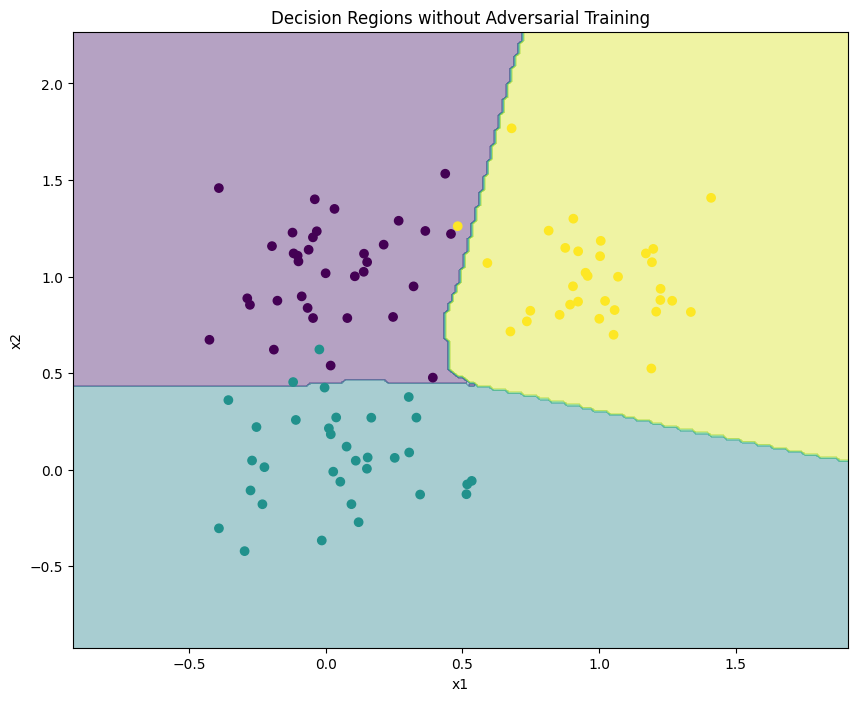

In [54]:
epochs = 1000
lr = 1e-3

net2 = Net()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net2.parameters(), lr=lr)

trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)
secmlt_model = BasePytorchClassifier(net2, trainer=trainer)
secmlt_model.train(tr_dataloader)

plot_decision_regions(secmlt_model.model, X_train, y_train, title="Decision Regions without Adversarial Training")
plot_decision_regions(secmlt_model.model, X_test, y_test, title="Decision Regions without Adversarial Training")

PROFESSOR CONSIDERATIONS:
- By looking at the shape of the boundaries, I can say that at training time the model did something a little "wiggly wiggly"
- There are a lot of points that can be easily used by the attacker -> closed to the boundary
- If the boundaries were a little more smooth, even paying the prize of misclassifying some points, maybe I would be able to better divide the samples
- In the training distribution, we can see that the bump is justified since there are a lot of blue and yellow points areound those areas -> might not be the best
- Reducing the number of epochs, the boundaries changes as well 
- The security of a model depends on how it was trained
    - Underfitting: my model is not so complex and has basically learnt nothing
    - Overfitting: the model finds all of the poles into the test_set  
If the model is very sensible to perturbations, it might mean that there is some overfitting going on -> I can see it because the boundaries are traced in a strange way

Given this network, we need to tweak the training loop that we saw at the beginning of the course.
Since we have a deep neural network, we **can not** compute adversarial training in closed form.

Hence, the only way is *approximating* the technique by iteratively create adversarial examples while optimizing.
This can be done in multiple ways:

* at each iteration, we create adversarial examples and include them in training (very time consuming)
* train the model for some epochs, compute adversarial attacks, include them in the training, repeat
* fine-tune the trained model with one attack with larger epsilon (less granular, but fast)

Here we are going to use a very easy approach, through Fast Gradient Sign Method (FGSM), which is a single-step attack with a large L-infinity norm.

PROFESSOR CONSIDERATIONS:
- We need to train a model in a way that takes into consideration the maximization of the error
- FGMS: computes the gradient toward the class you want to reach, normalizes it in the LINF box and moves there -> 1 large step attack
    - Interesting since it is not iterative -> not too much computational power needed

In [55]:
model= Net()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3 # we are estimating the amount of noise the attack could use

# PGD: the model tries to shape itself in a way to include all of the possible bubbles of the points in the training set
for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        # I can remove this part end use PGD, but I will pay the prize of the computation -> can be problematic
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data # gradient that maximizes the error (max ascent of the loss)
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.6018
Epoch 200, Loss: 0.5981
Epoch 300, Loss: 0.5968
Epoch 400, Loss: 0.5968
Epoch 500, Loss: 0.5924
Epoch 600, Loss: 0.5902
Epoch 700, Loss: 0.5878
Epoch 800, Loss: 0.5839
Epoch 900, Loss: 0.5831
Epoch 1000, Loss: 0.5822


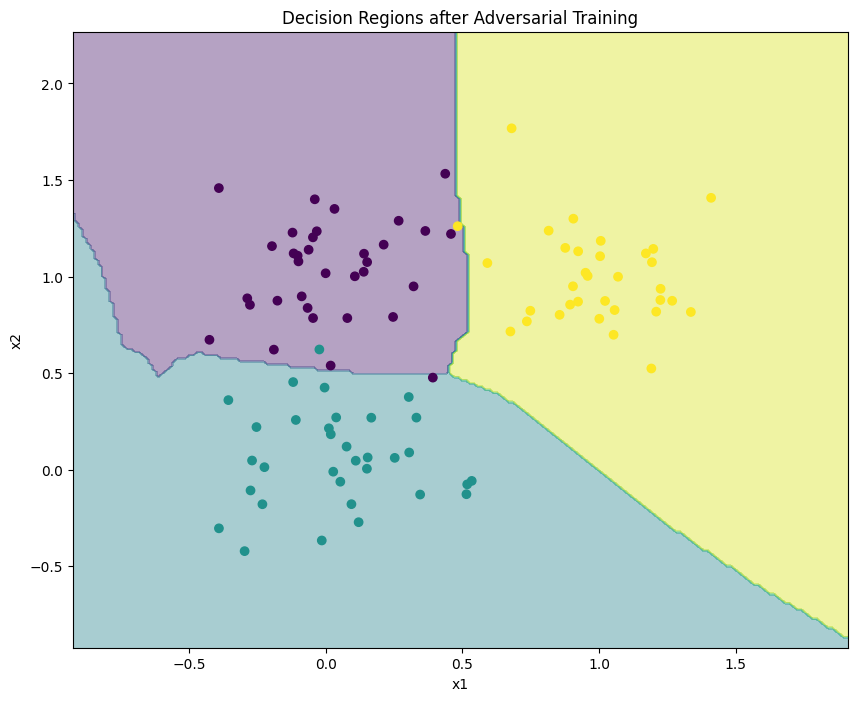

In [56]:
plot_decision_regions(model, X_test, y_test, title="Decision Regions after Adversarial Training")

- Much more complicated to get attack
- We still have to pay the price of mislabelling some points
- The request to moedl is very complicated

# Exercise 1
* Perform a security evaluation of both model under the same attack condition (for simplicity, use a PGD attack with varying epsilon)
* Plot the security evaluation curves in the same plot, and try to understand what the comparison is telling regarding the robustness of these models.

In [57]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

def security_evaluation_pgd_linf(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []
    for e in epsilons:
        attack_pgd = PGD(
            perturbation_model=LpPerturbationModels.LINF,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None, 
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack_pgd(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

The only security evaluation we want: untargeted
- It does not make sense to evaluate just one class
- In a binary classification case, targeted and untargeted are the same thing (2 lables) 
- If I have multiple labels, it might happen that some classes are very close to each other and some classes are very far from each other -> I would need to try all the targets and the results obtained would be hard to display and use -> less important information

In [ ]:
epsilons = torch.linspace(0, 1.5, steps=10)
iterations = 500
security_eval_no_at = security_evaluation_pgd_linf(secmlt_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)
security_eval_at = security_evaluation_pgd_linf(at_model, ts_dataloader, epsilons=epsilons,iterations=iterations, stepsize=0.1)

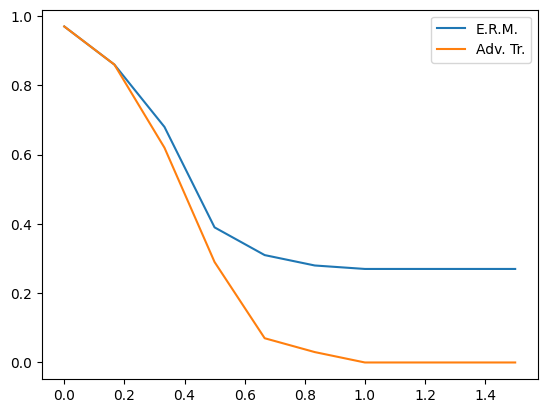

In [59]:
import matplotlib.pyplot as plt

plt.plot(epsilons.numpy(), security_eval_no_at, label='E.R.M.')
plt.plot(epsilons.numpy(), security_eval_at, label='Adv. Tr.')
plt.legend()
plt.show()

ERM: model trained with the Empirical Risk Minimization  
Adv. Tr: Adversarial trained model  
Statemens about the curves:
- The blue line is below the orange one
- Without perturbations, the orange is misclassifying more samples than the blue one -> since adversarial training is trying to push the boundary away from the samples, the samples close to the boundary are likely misclassified -> much complicated boundary -> I sacrifice some points of accuracy to gain robustness
- The attack seems to be correct since the blue curve is going to 0 -> the orage is not, but likely it is going to be 0 with more iterations
- The blue model drops faster; the orange one will eventually go to 0, but the graph is telling us that the orange model is harder to evade than the blue one
- Adversarial training not only bands the function to avoid the samples, but also starts to smooth the values of the function -> very large region where the model is completely flat (with just a tiny tiny slope) -> sometimes there can be a plateau

ADVERSARIAL TRAINING
- Some theories connect adversarial training with strong regularization 
- Another way to robustly train this model is, instead of minimizing just the loss, I also minimize the lamda with an LQ regularizer -> I am asking the model to not rely too much on specific features, and with the regularization parameter I am asking to all of the values of the feature to be kinda low -> the attacker needs to modify more of that to accomplish the attack
    - We are not going to see this method (regularization)
- Adversarial Training is a solution that guarantees empirically that the attacker has to sweat a lot to make the attack succeed -> I still can evade this, but it is harder

TAKE HOME MESSAGES: Adversarial training can be useful to inject some robustness in my model, but it has a cost: some points are misclassified -> I gain robustness in the long time

# Exercise 2

1. Try to change the attack used in adversarial training, for instance using LINF PGD or by increasing the epsilon. What happens if epsilon is too large?
2. What happens if the model does not have too many parameters? Can you successfully train it with adversarial training?
3. Change the norm of the security evaluations, and comment them again

1. Using PGD with epsilon = 0.3

In [77]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

pgd_attack_ex2 = PGD(
    perturbation_model=LpPerturbationModels.LINF,
    num_steps=10,
    step_size=0.01,
    epsilon=0.6,
    lb=-2, ub=2,
    backend=Backends.NATIVE
)

epochs = 2000
lr = 1e-3

model= Net()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()
trainer = BasePyTorchTrainer(optimizer=optimizer, loss=criterion, epochs=epochs)

at_model = BasePytorchClassifier(model, trainer=trainer)

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with PGD
        model.eval()
        current_tr_dataloader = DataLoader(TensorDataset(inputs, labels), batch_size=32)
        inputs_adv = pgd_attack_ex2(at_model, current_tr_dataloader)  
        x_adv, y_adv = next(iter(inputs_adv)) 

        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(x_adv)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

adv_model = BasePytorchClassifier(model)

Epoch 100, Loss: 0.1413
Epoch 200, Loss: 0.1360
Epoch 300, Loss: 0.1335
Epoch 400, Loss: 0.1315
Epoch 500, Loss: 0.1297
Epoch 600, Loss: 0.1283
Epoch 700, Loss: 0.1264
Epoch 800, Loss: 0.1256
Epoch 900, Loss: 0.1246
Epoch 1000, Loss: 0.1239
Epoch 1100, Loss: 0.1232
Epoch 1200, Loss: 0.1225
Epoch 1300, Loss: 0.1223
Epoch 1400, Loss: 0.1221
Epoch 1500, Loss: 0.1213
Epoch 1600, Loss: 0.1210
Epoch 1700, Loss: 0.1210
Epoch 1800, Loss: 0.1207
Epoch 1900, Loss: 0.1206
Epoch 2000, Loss: 0.1203


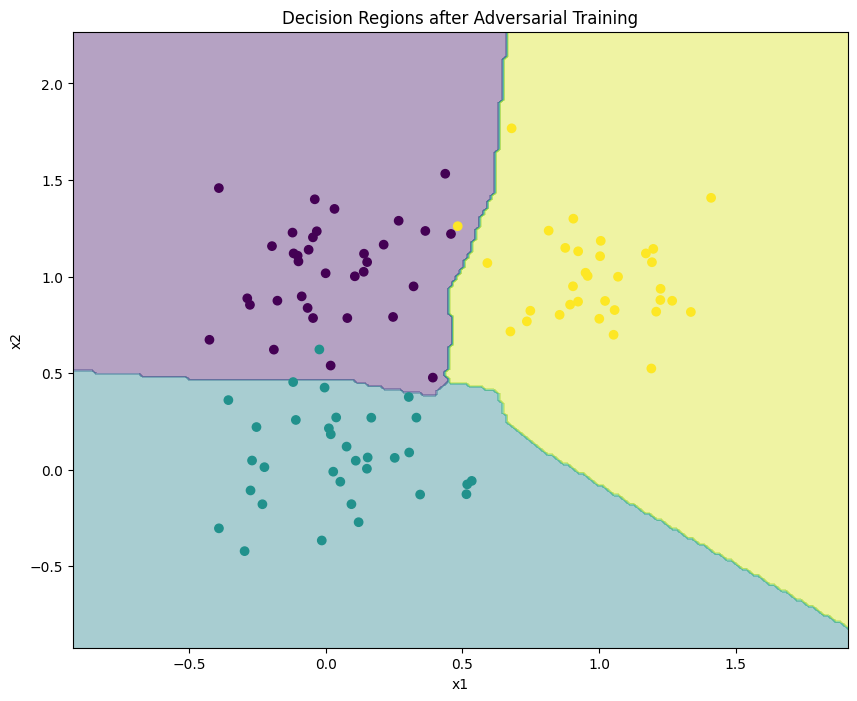

In [76]:
plot_decision_regions(model, X_test, y_test, title="Decision Regions after Adversarial Training")

2. I changed the NN to have less parameters and used the FGSM to create the adversarial dataset.

In [ ]:
class Net_ex(torch.nn.Module):
    def __init__(self):
        super(Net_ex, self).__init__()
        self.fc1 = torch.nn.Linear(2, 8)  
        self.fc2 = torch.nn.Linear(8, 8)
        self.fc3 = torch.nn.Linear(8, 3)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model_ex= Net_ex()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.CrossEntropyLoss()

epsilon = 0.3 

for epoch in range(epochs):
    running_loss = 0.0
    for inputs, labels in tr_dataloader:
        # Compute adversarial samples with 1-iteration attack
        model.eval()
        x = inputs.clone().detach().requires_grad_(True)
        outputs = model(x)
        loss = criterion(outputs, labels)
        loss.backward()
        gradient = x.grad.data 
        inputs_adv = x.data + epsilon * torch.sign(gradient)

        # Compute loss and backpropagate as usual
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs_adv)
        loss = criterion(outputs, labels)
        loss.backward()                 
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(tr_dataloader.dataset)
    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

at_model_ex = BasePytorchClassifier(model_ex)

Epoch 100, Loss: 0.4799
Epoch 200, Loss: 0.4969
Epoch 300, Loss: 0.4087
Epoch 400, Loss: 0.4627
Epoch 500, Loss: 0.4509
Epoch 600, Loss: 0.4283
Epoch 700, Loss: 0.3842
Epoch 800, Loss: 0.3687
Epoch 900, Loss: 0.3668
Epoch 1000, Loss: 0.3523


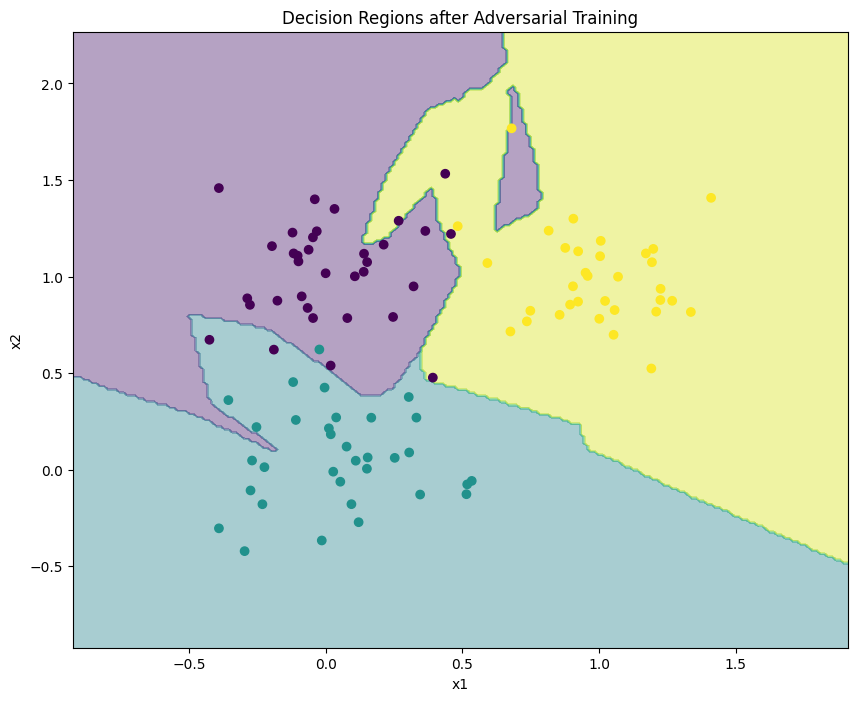

In [ ]:
plot_decision_regions(model, X_test, y_test, title="Decision Regions after Adversarial Training")

Reducing the number of parameters = reducing the intelligence of my model.  
More parameters we have, more capacity we gain; capacity is a concept related to how much complex the model we want to solve is and can I learn it.
The model with few parameters can be not very useful, since it starts to get dumb and it is not complex enought to understad its complexity

3.

In [ ]:
from secmlt.adv.evasion.pgd import PGD
from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels

def security_evaluation_pgd_linf(model, testloader, epsilons, iterations=100, stepsize=0.01):
    sec_eval_data = []
    for e in epsilons:
        attack_pgd = PGD(
            perturbation_model=LpPerturbationModels.L2,
            num_steps=iterations,
            step_size=stepsize,
            y_target=None, 
            epsilon=e,
            lb=-2,ub=2,
            backend = Backends.NATIVE)
        adv_dataloader = attack_pgd(model, testloader)
        robust_accuracy = Accuracy()(model, adv_dataloader)
        sec_eval_data.append(robust_accuracy)
    return sec_eval_data

If I used a model which is robust against LINF attacks, it should be robust under L1 norms, because LINF creates enormous manipulations (included the ones that the L1 can apply).  
It can happen that this does not happen, because these models are very complex